In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import corner

In [5]:
data = np.genfromtxt('../data/data_yerr.dat', names=True, comments='#', delimiter='&')
data

array([( 1., 201., 592., 61.), ( 2., 244., 401., 25.),
       ( 3.,  47., 583., 38.), ( 4., 287., 402., 15.),
       ( 5., 203., 495., 21.), ( 6.,  58., 173., 15.),
       ( 7., 210., 479., 27.), ( 8., 202., 504., 14.),
       ( 9., 198., 510., 30.), (10., 158., 416., 16.),
       (11., 165., 393., 14.), (12., 201., 442., 25.),
       (13., 157., 317., 52.), (14., 131., 311., 16.),
       (15., 166., 400., 34.), (16., 160., 337., 31.),
       (17., 186., 423., 42.), (18., 125., 334., 26.),
       (19., 218., 533., 16.), (20., 146., 344., 22.)],
      dtype=[('index', '<f8'), ('x', '<f8'), ('y', '<f8'), ('sigm_y', '<f8')])

In [6]:
x = data['x']  
y = data['y']
sigma_y = data['sigm_y']

In [7]:
def build_model(m, b):
    def model(x):
        return m * x + b
    return model

def lnlikelihood(m, b, x=data['x'], y=data['y'], sigma_y=sigma_y):
    model = build_model(m, b)
    lnlike = -0.5 * np.sum(np.log(2 * np.pi * sigma_y**2)) - np.sum((y - model(x))**2 / (2 * sigma_y**2))
    return lnlike

def prior(m, b):
    return 1

def posterior(m, b, x=data['x'], y=data['y'], sigma_y=sigma_y):
    return lnlikelihood(m, b, x, sigma_y) + prior(m, b)

initial_m = 1
initial_b = 10

m = initial_m
b = initial_b

p_current = posterior(m, b)

chain_m = [m]
chain_b = [b]
probs = [p_current]

In [8]:
niter = 1000000
for i in range(niter):
    samples = []
    m_proposed = norm.rvs(loc=m, scale=1)  
    b_proposed = norm.rvs(loc=b, scale=10)  

    p_p = posterior(m_proposed, b_proposed)
    
    
    α = np.exp(p_p - p_current) 
    u = np.random.uniform()
    accepted = u < α
    
    if accepted:
        m, b = m_proposed, b_proposed
        p_current = p_p
        
    chain_m.append(m)
    chain_b.append(b)
    probs.append(p_current)

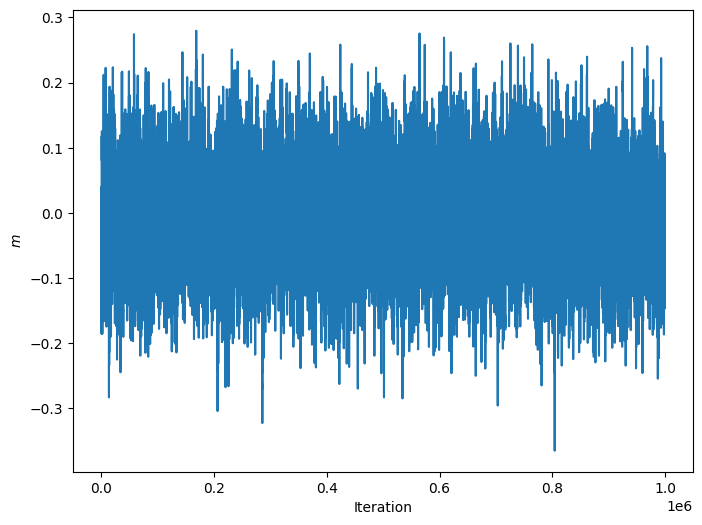

In [9]:
burnin_length = 1000

plt.figure(figsize=(8, 6))
plt.plot(chain_m[burnin_length:])
plt.xlabel('Iteration')
plt.ylabel('$m$')
plt.show()

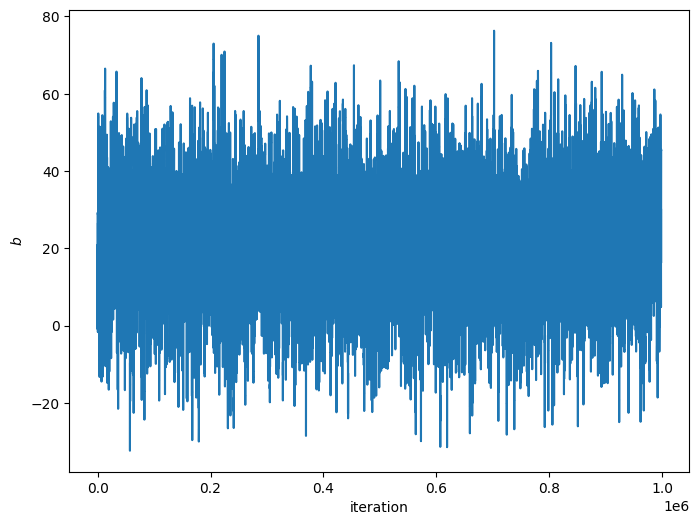

In [10]:
burnin_length = 2000

plt.figure(figsize=(8, 6))
plt.plot(chain_b[burnin_length:])
plt.xlabel('iteration')
plt.ylabel('$b$');

In [11]:
chain_m = np.array(chain_m)
chain_b = np.array(chain_b)
chain_data = np.column_stack((chain_m, chain_b, probs))
print(chain_data)

[[ 1.00000000e+00  1.00000000e+01 -8.06841292e+02]
 [ 1.00000000e+00  1.00000000e+01 -8.06841292e+02]
 [ 8.88146070e-01  7.00294655e+00 -6.26772481e+02]
 ...
 [-9.42324022e-02  4.54500255e+01 -8.54065319e+01]
 [-9.42324022e-02  4.54500255e+01 -8.54065319e+01]
 [-9.42324022e-02  4.54500255e+01 -8.54065319e+01]]


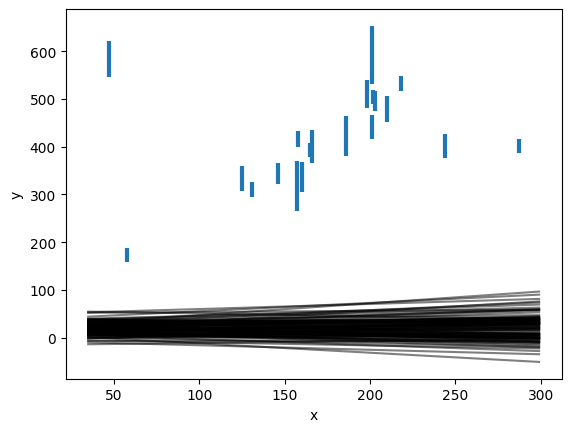

In [152]:
plt.errorbar(data['x'], data['y'], yerr=data['sigm_y'], linewidth=0, elinewidth=3, label='Data')
plt.xlabel('x')
plt.ylabel('y')

xlow, xhigh = plt.xlim()
test_x = np.linspace(xlow, xhigh, 100)

for _ in range(100):  
    m_sample = np.random.choice(chain_m)
    b_sample = np.random.choice(chain_b)
    
    model = lambda x: m_sample * x + b_sample
    predictions = model(test_x)

    plt.plot(test_x, predictions, color='black', alpha=0.5)

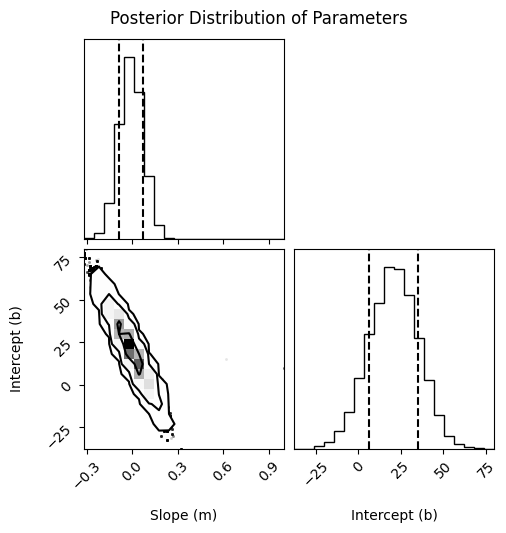

In [146]:
fig = corner.corner(np.vstack((chain_m, chain_b)).T, 
                     labels=["Slope (m)", "Intercept (b)"], 
                     quantiles=(0.16, 0.84), 
                     levels=(0.68, 0.95, 0.997))
fig.suptitle("Posterior Distribution of Parameters")
plt.show()


In [85]:
from scipy.optimize import minimize

Text(0.5, 1.0, '2D Posterior Density of m and b')

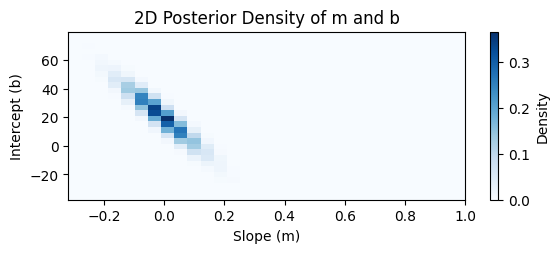

In [155]:
plt.subplot(2, 1, 1)
plt.hist2d(chain_m, chain_b, bins=30, cmap='Blues', density=True)
plt.colorbar(label='Density')
plt.xlabel('Slope (m)')
plt.ylabel('Intercept (b)')
plt.title('2D Posterior Density of m and b')

In [ ]:
plt.subplot(2, 1, 2)
sns.kdeplot(x=chain_m, y=chain_b, cmap='Reds', fill=True, thresh=0, levels=20)
plt.scatter(chain_m, chain_b, s=5, color='black', alpha=0.5)
plt.xlabel('Slope (m)')
plt.ylabel('Intercept (b)')
plt.title('Kernel Density Estimate of Posterior Distribution')

plt.tight_layout()
plt.show()

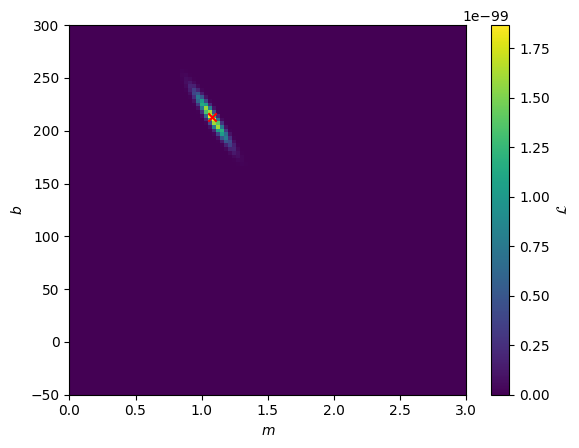

In [86]:
ngrid = 100

x0 = np.array([m, b])
res = minimize(lambda x:-lnlikelihood(x[0], x[1]), x0)

best_fit_m = res.x[0]
best_fit_b = res.x[1]

mmin, mmax = 0, 3
bmin, bmax = -50, 300
ms = np.linspace(mmin, mmax, ngrid)
bs = np.linspace(bmin, bmax, ngrid)

M, B = np.meshgrid(ms, bs)
pts = np.column_stack([M.ravel(), B.ravel()])
lnL = np.array([lnlikelihood(m, b) for m,b in pts]).reshape(M.shape)
plt.imshow(np.exp(lnL), extent=[mmin, mmax, bmin, bmax], origin='lower', aspect='auto')
plt.xlabel('$m$')
plt.ylabel('$b$')

cbar = plt.colorbar()
cbar.set_label('$\mathcal{L}$')

plt.scatter([best_fit_m], [best_fit_b], marker='x', color='r');

Q1.

In [87]:
df = pd.read_csv('../data/gaiadr3_solar_neighborhood.csv')
df

,mg,bp_rp,parallax
0,10.390250,2.731872,10.000008
1,8.608481,2.025819,10.000029
2,4.267759,0.880858,10.000032
3,10.506658,2.649735,10.000066
4,12.077941,2.940875,10.000111
...,...,...,...
227624,11.758283,2.834036,336.026602
227625,9.521769,2.215609,392.752945
227626,14.129570,4.184836,415.179416
227627,11.883816,2.833697,546.975940


In [88]:
filtered_data = df[df['parallax'] > 40]

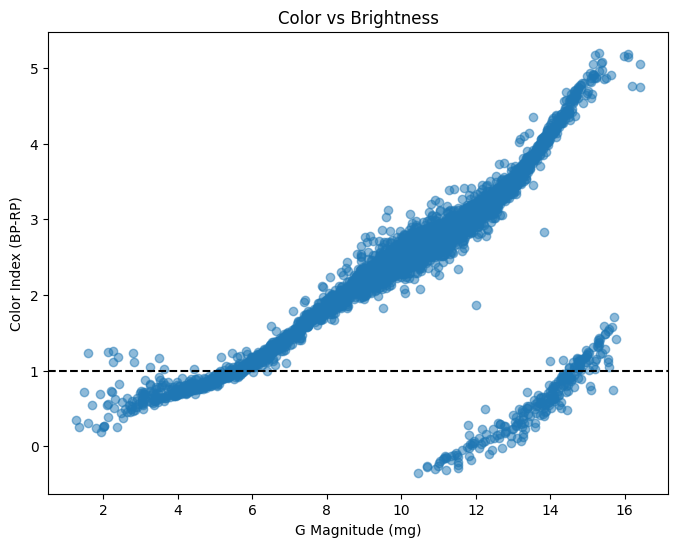

In [89]:
plt.figure(figsize=(8, 6))
plt.scatter(filtered_data['mg'], filtered_data['bp_rp'], alpha=0.5)  
plt.xlabel('G Magnitude (mg)')
plt.ylabel('Color Index (BP-RP)')
plt.title('Color vs Brightness')
plt.axhline(y=1, color='black', linestyle='--')
plt.show()

In [90]:
afterExclude_df = filtered_data[filtered_data['bp_rp'] > 1]  
print(afterExclude_df)

               mg     bp_rp    parallax
223559  11.544313  2.992254   40.002314
223560  13.563787  3.794676   40.004848
223561  10.197586  2.492932   40.007115
223562  12.769197  3.373776   40.014745
223563  12.413716  3.135756   40.019696
...           ...       ...         ...
227624  11.758283  2.834036  336.026602
227625   9.521769  2.215609  392.752945
227626  14.129570  4.184836  415.179416
227627  11.883816  2.833697  546.975940
227628  13.411743  3.804580  768.066539

[3549 rows x 3 columns]


Estimated Parameters:
Intercept (β0): 4.235507886898818
Slope (β1): 2.390520142522935
Standard Deviation (σ): 1.2042061825016164


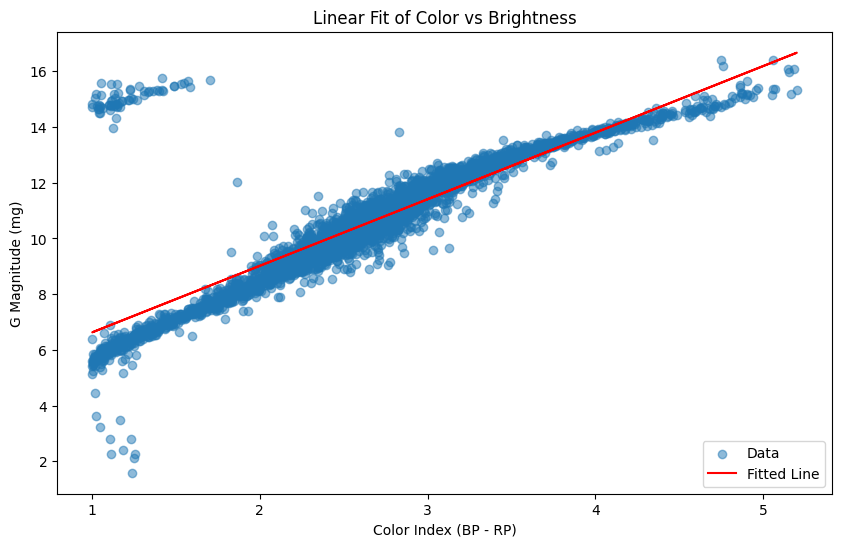

In [91]:
# Define the likelihood function
def negative_log_likelihood(params, x, y):
    beta_0, beta_1, sigma = params
    n = len(y)
    
    # Calculate the predicted values
    y_pred = beta_0 + beta_1 * x
    
    # Calculate the residuals
    residuals = y - y_pred
    
    # Log-likelihood
    if sigma <= 0:  # To ensure sigma is positive
        return np.inf
    
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2)) * np.sum(residuals**2)
    return -log_likelihood  # Return negative for minimization

# Prepare the data
x = afterExclude_df['bp_rp'].values
y = afterExclude_df['mg'].values

# Initial parameter guesses
initial_params = [0, 0, 1]  # beta_0, beta_1, sigma

# Minimize the negative log likelihood
result = minimize(negative_log_likelihood, initial_params, args=(x, y), bounds=[(None, None), (None, None), (1e-5, None)])

# Extract the estimated parameters
beta_0, beta_1, sigma = result.x
print(f"Estimated Parameters:\nIntercept (β0): {beta_0}\nSlope (β1): {beta_1}\nStandard Deviation (σ): {sigma}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, label='Data')
plt.plot(x, beta_0 + beta_1 * x, color='red', label='Fitted Line')
plt.xlabel('Color Index (BP - RP)')
plt.ylabel('G Magnitude (mg)')
plt.title('Linear Fit of Color vs Brightness')
plt.legend()
plt.show()
